In [41]:
%matplotlib inline

In [42]:
from __future__ import division

In [43]:
import numpy as np
from vtk_rw import read_vtk
from sklearn import linear_model
import scipy.stats as stats
import pickle
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import seaborn as sns
from graphs import graph_from_mesh
import gdist

In [44]:
colors = sns.color_palette('cubehelix', 10)


### prepare data

In [45]:
rh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_infl50.vtk'
lh_mesh_file='/scr/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_infl50.vtk'
full_mask_file='/scr/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
rh_t1_file='/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_1.5/rh_t1_avg_smooth_1.5.npy'
lh_t1_file='/scr/ilz3/myelinconnect/new_groupavg/t1/smooth_1.5/lh_t1_avg_smooth_1.5.npy'
embed_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
embed_dict_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'

In [46]:
lv,lf,_ = read_vtk(lh_mesh_file)
lh_t1 = np.load(lh_t1_file)
rv,rf,_ = read_vtk(rh_mesh_file)
rh_t1 = np.load(rh_t1_file)

mask = np.load(full_mask_file)

# prepare embedding (normalized from entry in dict)
pkl_in = open(embed_dict_file, 'r')
embed_dict=pickle.load(pkl_in)
pkl_in.close()

embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])
    #embed_masked /= np.linalg.norm(embed_masked, axis=0)

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, mask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

# extend mask to nodes that have a t1avg < 1500
full_t1 = np.concatenate((lh_t1, rh_t1))
fullmask = np.unique(np.concatenate((mask,np.where(full_t1<=1500)[0])))
fullmask = np.asarray(fullmask, dtype='int64')
nonmask_bigmask=np.delete(idcs, fullmask)

# mask embedding and t1
masked_t1 = np.delete(full_t1, fullmask)
masked_embed = np.delete(embed, fullmask, axis=0)

# mean center t1
#masked_t1 = masked_t1 - np.mean(masked_t1)

# normalize vectors so that BIC derivation works
#embed_norm =  np.sqrt(masked_embed.shape[0] / np.sum(masked_embed**2, axis=0))
#masked_embed *= embed_norm

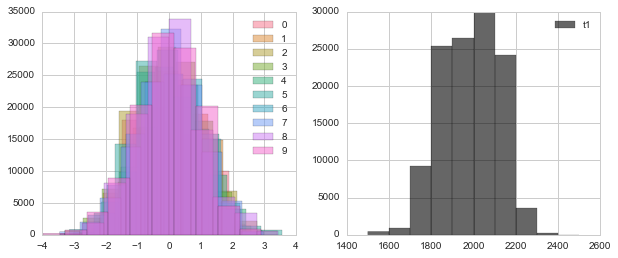

In [47]:
sns.set_context('notebook')
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
for i in range(10):
    plt.hist(masked_embed[:,i], label=str(i), alpha=0.5, color=sns.color_palette('husl', 10)[i]);
    plt.legend()
fig.add_subplot(122)
plt.hist(masked_t1, label='t1', color='black', alpha=0.6);
plt.legend()

### Estimate sigma2_res as noise in T1

In [48]:
Gl = graph_from_mesh(lv, lf)
Gr = graph_from_mesh(rv, rf)

In [49]:
# estimate precisely form direct neighbours
#sigma = 0.5*median_vertex(median_neighbor(abs(val(vertex)-val(neighbor))))/0.67448975
#the 0.5 is because the stdev of X-Y is 2x the stdev of X, Y; 
# the 0.67448975 because the median of a half gaussian distribution is sigma x sqrt(2) x erf-1(1/2) = sigma x 0.67448975

left_medians= []
for li in range(lv.shape[0]):
    neigh = Gl.neighbors(li)
    neigh_t1 = [full_t1[n] for n in neigh if not full_t1[n]==0]
    neigh_dist = [np.abs(full_t1[li] - nt) for nt in neigh_t1]
    left_medians.append(np.median(neigh_dist))
    
    
right_medians = []
for ri in range(rv.shape[0]):
    neigh = [x + lv.shape[0] for x in Gr.neighbors(ri)]
    neigh_t1 = [full_t1[n] for n in neigh if not full_t1[n]==0]
    neigh_dist = [np.abs(full_t1[ri+lv.shape[0]] - nt) for nt in neigh_t1]
    right_medians.append(np.median(neigh_dist))
    
    
all_medians = np.concatenate((left_medians, right_medians))
masked_medians = np.delete(all_medians, fullmask)
noise_median = 0.5*np.nanmedian(masked_medians)/0.67448975
sigma2_res = noise_median**2
print noise_median
print sigma2_res

11.5441449936
133.267283633


### set variance as % of T1 range

In [33]:
t1_range = masked_t1.max()-masked_t1.min()
print t1_range

1001.01828093


In [34]:
percent_estimated = noise_median  * 100 / t1_range
print percent_estimated

1.55569735719


In [84]:
#set_percent = 10
#sigma_res = set_percent * t1_range / 100
#sigma2_res = sigma_res**2
#print sigma_res
#print sigma2_res

93.5140480518
8744.87718304


### BIC

In [50]:
def BIC(params, residuals, data, sigma2_res):
    
    p = params.shape[0]
    n = residuals.shape[0]
    data_range = data.max()-data.min()
    
    bic = (1-p) * np.log(2*np.pi*sigma2_res) + (1./sigma2_res) * (1./n) * np.sum(residuals**2) + p*np.log(data_range**2)
    
    return bic

### run single model for testing

In [51]:
maps = range(10)
clf = linear_model.LinearRegression()
clf.fit(masked_embed[:,maps], masked_t1)

modelled_fit = clf.predict(masked_embed[:,maps])
residuals = masked_t1 - clf.predict(masked_embed[:,maps])

print 'coeffs', clf.coef_
print 'R squared', clf.score(masked_embed[:,maps], masked_t1)
print 'BIC', BIC(clf.coef_, residuals, masked_t1, sigma2_res)

coeffs [-71.11913278  24.9353592    4.68860363   4.21976017 -34.9781779
 -41.89772823 -29.65496524  11.51373708  22.62030019 -26.25885703]
R squared 0.605028683534
BIC 131.150409466


### iterate over all possible models

In [52]:
maps = range(10)
combinations = []

for i in range(len(maps)):
    element = [list(x) for x in itertools.combinations(maps, i+1)]
    combinations.extend(element)

In [53]:
df = pd.DataFrame(columns=["Maps", "Pearson's r", "R squared", "BIC", "Residuals"], index=range(len(combinations)))
for c in range(len(combinations)):
    maps=combinations[c]
    clf = linear_model.LinearRegression()
    clf.fit(masked_embed[:,maps], masked_t1)

    modelled_fit = clf.predict(masked_embed[:,maps])
    residuals = masked_t1 - clf.predict(masked_embed[:,maps])

    df["Maps"][c] = tuple(maps)
    df["Pearson's r"][c] = stats.pearsonr(modelled_fit, masked_t1)[0]
    df["R squared"][c] = clf.score(masked_embed[:,maps], masked_t1)
    df["BIC"][c] = BIC(clf.coef_, residuals, masked_t1, sigma2_res)
    df["Residuals"][c] = (1./residuals.shape[0]) * np.sum(residuals**2)

In [54]:
df.iloc[np.argmin(df["BIC"])]

Maps           (0, 4, 5)
Pearson's r    0.6675115
R squared      0.4455717
BIC             103.1571
Residuals       10017.03
Name: 76, dtype: object

In [ ]:
len_maps = [len(df['Maps'][i]) for i in range(len(df['Maps']))]
map_transitions = np.asarray([(x+.5) for x in range(len(len_maps)-1) if len_maps[x]!=len_maps[x+1]])
map_transitions = map_transitions[:-1]

In [ ]:
import seaborn as sns
sns.set_context('notebook', font_scale=2)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
plt.plot(df["BIC"], color=colors[3], alpha=1)
ax1.vlines(map_transitions, df["BIC"].min(), df["BIC"].max(), linestyle='--', linewidth=3, colors=colors[0])
plt.ylabel('BIC')
plt.xlabel('# Model [increasing complexity]')
plt.xticks(np.arange(0,1023, 100));
plt.xlim([0,1023])
ax2 = fig.add_subplot(212)
norm_res = df["Residuals"]/sigma2_res
plt.plot(norm_res, color=colors[5], alpha=1)
ax2.vlines(map_transitions, norm_res.min(), norm_res.max(), linestyle='--', linewidth=3, colors=colors[0])
plt.ylabel('Normalized residuals')
plt.xlabel('# Model [increasing complexity]')
plt.xticks(np.arange(0,1023, 100));
plt.xlim([0,1023])
fig.tight_layout()
#fig.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/model_comparison_10maps_allmodels_neighb_prec.png')

In [ ]:
upper_bound = 300
sns.set_context('notebook', font_scale=2)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)
plt.plot(df["BIC"][:upper_bound], color=colors[3], alpha=1)
ax1.vlines(map_transitions[np.where(map_transitions<upper_bound)], df["BIC"][:upper_bound].min(), df["BIC"][:upper_bound].max(), linestyle='--', linewidth=3, colors=colors[0])
plt.ylabel('BIC')
plt.xlabel('# Model [increasing complexity]')
#plt.xticks(np.arange(0,upper_bound, 10));
plt.xlim([0,upper_bound])
ax2 = fig.add_subplot(212)
norm_res = df["Residuals"][:upper_bound]/sigma2_res
plt.plot(norm_res, color=colors[5], alpha=1)
ax2.vlines(map_transitions[np.where(map_transitions<upper_bound)], norm_res.min(), norm_res.max(), linestyle='--', linewidth=3, colors=colors[0])
plt.ylabel('Normalized Residuals')
plt.xlabel('# Model [increasing complexity]')
#plt.xticks(np.arange(0,upper_bound, 10));
plt.xlim([0,upper_bound])
fig.tight_layout()
#fig.savefig('/scr/ilz3/myelinconnect/new_groupavg/pics/model_comparison_10maps_100models_neighb_prec.png')

In [22]:
df.to_csv('/scr/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/model_comparison_10maps.csv')

### Schwartz weights

schwartz[i] can be interpreted as the probability that i is the best model ( in the BIC sense, ie the true generating model is beyond the candidate models, hence schwartz[i] is the probability for i to be the true generating model)

In [51]:
def Schwartz(bic_all):
    
    best = bic_all[np.argmin(bic_all)]
    schwartz = []
    
    for model in bic_all:
        bic_diff = model - best
        schwartz.append(np.exp(-bic_diff/2.))
    
    schwartz = schwartz / np.sum(schwartz)
    
    return schwartz
    

### Evidence ration of Schwartz weights
expressing how many times more likely model i is than model j
resp. normalized probability that i is preferred over j